#### Import libraries

In [42]:
from pprint import pprint

import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import LdaMulticore
import gensim.corpora as corpora
from wordcloud import WordCloud

from sem_covid.services.data_registry import Dataset
from sem_covid.services.pwdb_base_experiment import PWDBBaseExperiment

#### Download dataset

In [2]:
pwdb = Dataset.PWDB.fetch()

[2021-05-11 10:48:21,853] {data_source.py:46} INFO - Fetching ds_pwdb from the remote source
[2021-05-11 10:48:21,919] {base.py:262} INFO - POST http://srv.meaningfy.ws:9200/ds_pwdb/_count [status:200 request:0.065s]
[2021-05-11 10:48:26,254] {base.py:262} INFO - POST http://srv.meaningfy.ws:9200/ds_pwdb/_search?scroll=5m&size=1000 [status:200 request:4.109s]


N/A% (0 of 1123) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

[2021-05-11 10:48:27,554] {base.py:262} INFO - POST http://srv.meaningfy.ws:9200/_search/scroll [status:200 request:0.788s]


100% (1123 of 1123) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


#### Use base experiment function to concatenate and clean text data

In [3]:
pwdb_preprocessing = PWDBBaseExperiment.prepare_pwdb_data(pwdb)

In [19]:
pwdb_text_data = pwdb_preprocessing['descriptive_data']
pwdb_reset_index = pwdb_text_data.reset_index(drop=True)


#### Create wordcloud

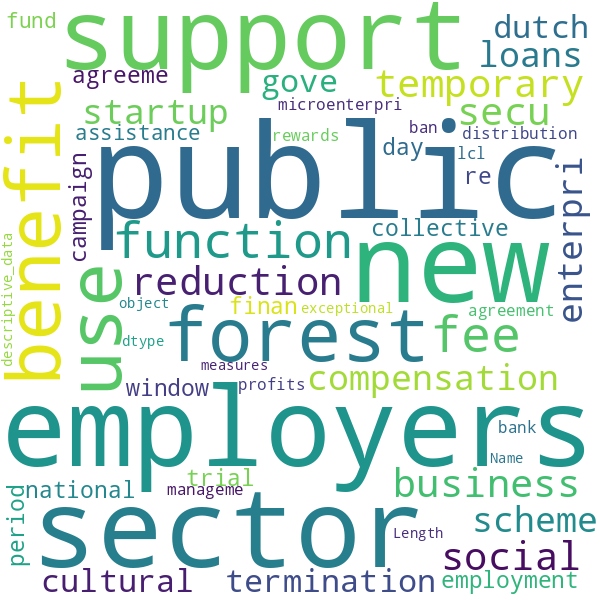

In [68]:
wordcloud = WordCloud(background_color="white", max_words=5000, width=600,
                     height=600, contour_width=3, contour_color='steelblue')

v = wordcloud.generate(str(pwdb_reset_index))

v.to_image()

#### Put words into dictionary

In [75]:
id2word = corpora.Dictionary(pwdb_reset_index)

corpus = [id2word.doc2bow(text) for text in pwdb_reset_index]

[2021-05-11 17:53:32,102] {dictionary.py:200} INFO - adding document #0 to Dictionary(0 unique tokens: [])
[2021-05-11 17:53:32,265] {dictionary.py:205} INFO - built Dictionary(12645 unique tokens: ['', 'according', 'act', 'activity', 'affected']...) from 1123 documents (total 207072 corpus positions)
[2021-05-11 17:53:32,266] {utils.py:448} INFO - Dictionary lifecycle event {'msg': "built Dictionary(12645 unique tokens: ['', 'according', 'act', 'activity', 'affected']...) from 1123 documents (total 207072 corpus positions)", 'datetime': '2021-05-11T17:53:32.266613', 'gensim': '4.0.1', 'python': '3.8.5 (default, Jan 27 2021, 15:41:15) \n[GCC 9.3.0]', 'platform': 'Linux-5.8.0-50-generic-x86_64-with-glibc2.29', 'event': 'created'}


#### View the frequency of each word

In [38]:
term_frequency = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
term_frequency

[[('', 1),
  ('according', 2),
  ('act', 1),
  ('activity', 2),
  ('affected', 1),
  ('agriculture', 2),
  ('amendments', 2),
  ('annual', 1),
  ('approximately', 1),
  ('article', 2),
  ('associations', 1),
  ('beneficiaries', 1),
  ('benefit', 3),
  ('broadens', 1),
  ('business', 1),
  ('carry', 1),
  ('case', 1),
  ('caused', 1),
  ('causes', 1),
  ('certain', 1),
  ('charge', 2),
  ('circumstances', 3),
  ('citizens', 1),
  ('collected', 1),
  ('common', 3),
  ('companies', 2),
  ('company', 2),
  ('compensation', 1),
  ('condition', 1),
  ('consequences', 2),
  ('contributions', 2),
  ('covered', 1),
  ('croatia', 1),
  ('croatian', 1),
  ('currently', 1),
  ('damage', 1),
  ('decided', 1),
  ('decrease', 1),
  ('different', 1),
  ('disrupts', 2),
  ('distributed', 1),
  ('economic', 2),
  ('eliminate', 2),
  ('environment', 1),
  ('events', 1),
  ('exceeding', 1),
  ('fee', 4),
  ('forest', 7),
  ('forestry', 2),
  ('forests', 3),
  ('function', 3),
  ('functions', 3),
  ('funds

#### LDA model training

In [32]:
num_topics = 10
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

pprint(lda_model.print_topics())

[2021-05-11 11:10:45,060] {ldamodel.py:567} INFO - using symmetric alpha at 0.1
[2021-05-11 11:10:45,061] {ldamodel.py:567} INFO - using symmetric eta at 0.1
[2021-05-11 11:10:45,063] {ldamodel.py:484} INFO - using serial LDA version on this node
[2021-05-11 11:10:45,080] {ldamulticore.py:238} INFO - running online LDA training, 10 topics, 1 passes over the supplied corpus of 1123 documents, updating every 6000 documents, evaluating every ~1123 documents, iterating 50x with a convergence threshold of 0.001000
[2021-05-11 11:10:45,081] {ldamulticore.py:247} WARNING - too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
[2021-05-11 11:10:45,082] {ldamulticore.py:279} INFO - training LDA model using 3 processes
[2021-05-11 11:10:45,110] {ldamulticore.py:294} INFO - PROGRESS: pass 0, dispatched chunk #0 = documents up to #1123/1123, outstanding queue size 1
[2021-05-11 11:10:45,971] {ldamodel.py:1185} INFO - topic #7 (0.10

#### Analyzing LDA model results

In [77]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.010504 -0.002375       1        1  16.765341
3     -0.006919 -0.010375       2        1  16.174302
7      0.000027 -0.013464       3        1  15.140464
1     -0.013097  0.002923       4        1  12.514799
2     -0.015010  0.019376       5        1  12.482055
5      0.005070 -0.011039       6        1   8.078960
8     -0.010609  0.006695       7        1   7.168883
9      0.009858 -0.016436       8        1   6.146985
4     -0.001485  0.012048       9        1   3.691583
6      0.042669  0.012648      10        1   1.836628, topic_info=             Term         Freq        Total Category  logprob  loglift
158        social  1962.000000  1962.000000  Default  30.0000  30.0000
260        scheme   754.000000   754.000000  Default  29.0000  29.0000
118         covid  1855.000000  1855.000000  Default  28.0000  28.0000
787  unemployment   444.000000   444.000000  Default  27.0000  27.0000
120     employees  1649.000000  1649.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
344        sector    10.765987   768.926144  Topic10  -5.8672  -0.2714
168          work    11.869972  1254.239737  Topic10  -5.7696  -0.6630
505       working    11.275622   975.204399  Topic10  -5.8209  -0.4628
136         march    10.880500   947.219428  Topic10  -5.8566  -0.4693
120     employees    10.498455  1649.314579  Topic10  -5.8924  -1.0596

[853 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
7180       1  0.101624  accident
7180       2  0.101624  accident
7180       3  0.101624  accident
7180       4  0.101624  accident
7180       5  0.203248  accident
...      ...       ...       ...
11609      1  0.097097      zsss
11609      3  0.097097      zsss
11609      4  0.097097      zsss
11609      5  0.679680      zsss
11610      5  0.673569     zveza

[2609 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 8, 2, 3, 6, 9, 10, 5, 7])